In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.subplots as sp
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import tslearn.clustering as tsc
import statsmodels.api as sm
import patsy
import researchpy as rp
from sklearn import datasets 
from tabulate import tabulate
import importlib
import regression_formulas

base_directory = "C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning"
data_directory = os.path.join(base_directory, 'edp_data')
cleaned_data_directory = os.path.join(base_directory, 'resampled_30min_data')

Now, once we have the best profile class assignments, let's find the regression model


In [6]:

biggest_cluster = 3 # currently hard coded but will need to be changed to be dynamic later

df = pd.read_csv(os.path.join(base_directory, 'df_for_regression_unconverted.csv'))
print(df.head())
# Assuming your data is in a pandas DataFrame called `df`
# and the response variable is `profile_class`
sub_df = pd.read_csv(os.path.join(base_directory, 'sub_clustering.csv'))
sub_df["Date"] = pd.to_datetime(sub_df["Date"])
df["date"] = pd.to_datetime(df["date"])
print(sub_df.head())
for idx, row in sub_df.iterrows():
    # Locate the matching rows
    match = (df["date"] == row["Date"]) & (df["site_ID"] == row["Site_ID"])
    if match.any():
        # Check if the current profile_class is 3
        if (df.loc[match, "profile_class"] != biggest_cluster).any():
            print("something's wrong")
        else:
            # Update the profile_class with the new value
            df.loc[match, "profile_class"] = row["Profile_Class_Real"]


C:\Users\CEEM04\AppData\Local\Temp\ipykernel_13740\1154687648.py:3: DtypeWarning:

Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.



   Unnamed: 0        date site_ID  profile_class  climate_zone  \
0           0  2023-01-01   S0024              0             2   
1           1  2023-01-02   S0024              0             2   
2           2  2023-01-03   S0024              0             2   
3           3  2023-01-04   S0024              0             2   
4           4  2023-01-05   S0024              0             2   

  aircon_type_simplified property_construction  weather_station_number  \
0                 Ducted          Brick veneer                   40861   
1                 Ducted          Brick veneer                   40861   
2                 Ducted          Brick veneer                   40861   
3                 Ducted          Brick veneer                   40861   
4                 Ducted          Brick veneer                   40861   

  num_bedrooms  num_occupants  max_air_temperature  min_air_temperature  
0            4              4                 27.3                 21.0  
1         

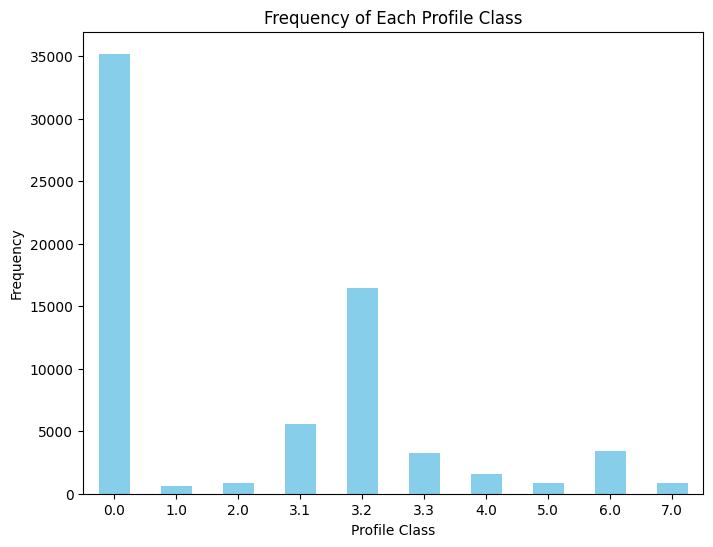

In [7]:
# Create figure of how many observations belong in each profile class 
frequency_counts = df['profile_class'].values.flatten()

# Count the occurrences of each number (cluster label)
counts = pd.Series(frequency_counts).value_counts()

# Plot the frequency of each number
plt.figure(figsize=(8, 6))
counts.sort_index().plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Profile Class')
plt.ylabel('Frequency')
plt.title('Frequency of Each Profile Class')
plt.xticks(rotation=0)
plt.show()

In [8]:

# Convert categorical variables like 'construction_type' and 'climate_zone' to categorical
df['property_construction'] = df['property_construction'].astype('category')
df['aircon_type_simplified'] = df['aircon_type_simplified'].astype('category')
df['num_bedrooms'] = pd.to_numeric(df['num_bedrooms'], errors='coerce').fillna(5)
df['num_bedrooms'] = df['num_bedrooms'].astype('int')
df['num_occupants'] = df['num_occupants'].astype('int')
df['profile_class'] = df['profile_class'].astype('category')
df['climate_zone'] = df['climate_zone'].astype('category')

def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    elif month in [9, 10, 11]:
        return 'Spring'

# Function to determine if the day is a weekend or weekday
def get_weekday_or_weekend(date):
    # Weekdays are Monday (0) to Friday (4), weekends are Saturday (5) and Sunday (6)
    if date.weekday() >= 5:
        return 'WE'  # Weekend
    else:
        return 'WD'  # Weekday

# Convert date to datetime if needed
df['date'] = pd.to_datetime(df['date'])

# Then create the new columns
df['season'] = df['date'].dt.month.apply(get_season)
df['day_type'] = df['date'].apply(get_weekday_or_weekend)

df['profile_class'] = df['profile_class'].map(lambda x: f'Class_{x}')

# remove column named 'index'
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# write df to csv
df.to_csv(os.path.join(base_directory, 'df_for_regression.csv'), index=False)

In [10]:


importlib.reload(regression_formulas)

from regression_formulas import analyze_multinomial_regression, fit_multinomial_regression, get_categorical_stats, get_numeric_stats, analyze_multinomial_regression
df = pd.read_csv('df_for_regression.csv')
# Define your columns
numeric_columns = ['min_air_temperature', 'max_air_temperature', 
                  'num_bedrooms', 'num_occupants']
categorical_columns = ['property_construction', 'aircon_type_simplified', 
                      'climate_zone', 'season', 'day_type']

#get_categorical_stats(df, categorical_columns)

get_numeric_stats(df, numeric_columns)

# Your formula (simplified since we're handling the column types separately)
formula = 'profile_class ~ min_air_temperature + max_air_temperature + property_construction + aircon_type_simplified + num_bedrooms + num_occupants + climate_zone + season + day_type'

# Run the analysis
results, error_message = analyze_multinomial_regression(df, formula, numeric_columns, categorical_columns)


print(error_message)


68501
Optimization terminated successfully.
         Current function value: 1.303395
         Iterations: 1128
         Function evaluations: 1132
         Gradient evaluations: 1132
Number of observations: 68501
None


In [11]:

print(results.summary())



KeyboardInterrupt: 

In [80]:

list_of_response_classes = [col.split('[')[1].split(']')[0] for col in results.model.data.orig_endog]

with open("response_classes.pkl", "wb") as f:
    pickle.dump(list_of_response_classes, f)

In [77]:
with open("multinomial_logit_model.pkl", "wb") as file: 
    pickle.dump(results, file)

In [64]:
import pandas as pd
from tabulate import tabulate

# Get the coefficients into a DataFrame
coef_df = pd.DataFrame(results.params)

# Try to get p-values
try:
    pvalues = results.pvalues
    has_pvalues = True
except AttributeError:
    has_pvalues = False
    print("doesn't got p-values")

# Create a function to format coefficients (and add stars if we have p-values)
def format_coef(x, p=None):
    if has_pvalues and p is not None:
        stars = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
        return f"{x:.3f}{stars}"
    return f"{x:.3f}"

# Create formatted table
formatted_table = coef_df.copy()
if has_pvalues:
    for col in formatted_table.columns:
        formatted_table[col] = [
            format_coef(x, p) for x, p in zip(coef_df[col], pvalues[col])
        ]
else:
    formatted_table = formatted_table.applymap(lambda x: format_coef(x))

# Extract the response class names from the column headers
response_classes = [col.split('[')[1].split(']')[0] for col in results.model.data.orig_endog][1:]

# Rename columns with actual response class names
formatted_table.columns = response_classes

# Print the table
print(tabulate(formatted_table, headers='keys', tablefmt='pipe', showindex=True))

# Optionally save to CSV


|                                                        | Class_1.0   | Class_2.0   | Class_3.1   | Class_3.2   | Class_3.3   | Class_4.0   | Class_5.0   | Class_6.0   | Class_7.0   |
|:-------------------------------------------------------|:------------|:------------|:------------|:------------|:------------|:------------|:------------|:------------|:------------|
| Intercept                                              | -7.776***   | -10.943***  | -2.790***   | -2.330***   | 0.171       | -5.458***   | 1.319***    | -9.027***   | -2.163***   |
| property_construction[T.Concrete]                      | 3.058***    | 0.518*      | 0.285**     | 1.163***    | 0.075       | 0.680***    | -0.625      | 0.301*      | 1.563***    |
| property_construction[T.Double brick]                  | 0.382*      | 0.849***    | 0.019       | 0.274***    | -0.464***   | 0.532***    | 0.163       | 0.091       | -0.616***   |
| property_construction[T.Lightweight]                   | 1.658***    | -0

In [ ]:
#formatted_table.to_csv("formatted_table_of_multinomial_results.csv")

In [65]:
print(response_classes)

['Class_1.0', 'Class_2.0', 'Class_3.1', 'Class_3.2', 'Class_3.3', 'Class_4.0', 'Class_5.0', 'Class_6.0', 'Class_7.0']


In [66]:
#site_specific = df[df['site_ID'] == 'S0024']

predicted_probabilities = results.predict()
# find length of list 
print(len(predicted_probabilities))
print(predicted_probabilities.shape)

68501
(68501, 10)


In [67]:
df = pd.read_csv('df_for_regression.csv')

df = df.dropna()
df = df[df['min_air_temperature'] > -10]
# add an item first to response_classes

if 'Class_0.0' not in response_classes:
    response_classes.insert(0, 'Class_0.0')

print(len(predicted_probabilities))
print(len(df))

68501
68501


In [68]:
importlib.reload(regression_formulas)
df = pd.read_csv('df_for_regression.csv')
# remove any rows from df that contain NA values
df = df.dropna()
# remove any rows from df that have a value for min_air_temperature that is less than -10
df = df[df['min_air_temperature'] > -10]
df_with_probabilities = regression_formulas.add_probabilities_to_dataframe(df, predicted_probabilities, response_classes)

['Class_0.0', 'Class_1.0', 'Class_2.0', 'Class_3.1', 'Class_3.2', 'Class_3.3', 'Class_4.0', 'Class_5.0', 'Class_6.0', 'Class_7.0']
10


In [45]:
print(len(range(10)))

10


In [49]:
print(df_with_probabilities)

             date site_ID profile_class  climate_zone aircon_type_simplified  \
0      2023-01-01   S0024     Class_0.0             2                 Ducted   
1      2023-01-02   S0024     Class_0.0             2                 Ducted   
2      2023-01-03   S0024     Class_0.0             2                 Ducted   
3      2023-01-04   S0024     Class_0.0             2                 Ducted   
4      2023-01-05   S0024     Class_0.0             2                 Ducted   
...           ...     ...           ...           ...                    ...   
68513  2023-12-27   W0352     Class_3.2             5                 Ducted   
68514  2023-12-28   W0352     Class_3.2             5                 Ducted   
68515  2023-12-29   W0352     Class_3.2             5                 Ducted   
68516  2023-12-30   W0352     Class_0.0             5                 Ducted   
68517  2023-12-31   W0352     Class_3.2             5                 Ducted   

      property_construction  weather_st

In [50]:
df_with_probabilities.to_csv('df_for_regression_with_probabilities.csv', index=False)

In [71]:
just_probabilities = df_with_probabilities[['date', 'site_ID', 'Class_0.0_Probability', 'Class_1.0_Probability', 'Class_2.0_Probability', 'Class_3.1_Probability', 
'Class_3.2_Probability', 'Class_3.3_Probability', 'Class_4.0_Probability', 'Class_5.0_Probability', 'Class_6.0_Probability', 'Class_7.0_Probability']]

just_probabilities.to_csv('just_probabilities.csv', index=False)

Final Outputs from this script:
- formatted_table_of_multinomial_results.csv
- pickle of the multinomial model
- pickle of the response classes
Next Step is to go to the regression_analysis script to create the regression model

Graveyard below

In [ ]:
counts = df['profile_class'].value_counts()
print(counts)

# Create pie chart
plt.figure(figsize=(6, 6))
counts.plot.pie(startangle=90, labels=counts.index)

# Add title
plt.title("Distribution of Profile Classes")
plt.ylabel("")  # Remove y-axis label for aesthetics
plt.show()

In [ ]:

from tabulate import tabulate

# Create MultiIndex for columns
columns_tuples = []
for i in range(1, 10):
    columns_tuples.extend([
        (f'Profile Class {i}', 'Coefficient'),
        (f'Profile Class {i}', 'Std. Error')
    ])
columns = pd.MultiIndex.from_tuples(columns_tuples)

# Create table data
table_data = []
for idx in results.params.index:
    row = []
    for i in range(9):
        coef = results.params[i][idx]
        se = results.bse[i][idx]
        pval = results.pvalues[i][idx]
        
        # Add bold tags for significant coefficients
        coef_str = f"<b>{coef:.3f}</b>" if pval < 0.05 else f"{coef:.3f}"
        se_str = f"({se:.3f})"
        
        row.extend([coef_str, se_str])
    table_data.append(row)

# Create DataFrame
table_df = pd.DataFrame(table_data, index=results.params.index, columns=columns)

# Create HTML with updated styling
html_table = """
<style>
    table {
        border-collapse: collapse;
        width: 100%;
        margin: 20px 0;
        font-family: Arial, sans-serif;
    }
    th, td {
        padding: 8px;
        text-align: center;
        border: 1px solid #ddd;
    }
    th {
        background-color: #f5f5f5;
    }
    tr:nth-child(even) {
        background-color: #f9f9f9;
    }
    .header-row {
        border-bottom: 2px solid #ddd;
    }
    .std-error {
        color: #666;
    }
    caption {
        margin-bottom: 10px;
        font-weight: bold;
    }
    .model-stats {
        margin-top: 20px;
        border-top: 1px solid #ddd;
        padding-top: 10px;
    }
    .model-stats table {
        width: auto;
        margin: 10px 0;
    }
    .model-stats td {
        padding: 5px 15px;
    }
</style>
""" + table_df.to_html(
    classes='styled-table',
    justify='center',
    escape=False  # Allow HTML tags in table cells
)

# Add significance note and model statistics
html_table += """
<p style='font-style: italic; margin-top: 10px;'>Note: Bold coefficients indicate p < 0.05</p>

<div class='model-stats'>
    <h3>Model Statistics:</h3>
    <table>
        <tr>
            <td><b>Pseudo R-squared:</b></td>
            <td>{:.3f}</td>
        </tr>
        <tr>
            <td><b>Log-Likelihood:</b></td>
            <td>{:.3f}</td>
        </tr>
        <tr>
            <td><b>Number of Observations:</b></td>
            <td>{}</td>
        </tr>
        <tr>
            <td><b>AIC:</b></td>
            <td>{:.3f}</td>
        </tr>
        <tr>
            <td><b>BIC:</b></td>
            <td>{:.3f}</td>
        </tr>
        <tr>
            <td><b>Convergence Achieved:</b></td>
            <td>{}</td>
        </tr>
    </table>
</div>
""".format(
    results.prsquared,
    results.llf,
    results.nobs,
    results.aic,
    results.bic,
    results.converged
)

# Save to file
with open('multinomial_results_with_sub_clustering.html', 'w') as f:
    f.write(html_table)

print("Table has been saved to 'multinomial_results.html'")


In [64]:
from sklearn.metrics import classification_report
import numpy as np

df = pd.read_csv('df_for_regression.csv')
df_processed = df[df['min_air_temperature'] >= -10.8]
df_processed = df_processed.dropna()
# Extract true labels
y_true = df_processed['profile_class']


# Predict class probabilities (for each observation, you get a probability for each class)
predicted_probabilities = results.predict()

# Get the predicted class indices (the index of the highest probability)
y_pred_indices = np.argmax(predicted_probabilities, axis=1)

# Map the predicted class indices to the actual class labels (e.g., 'Class_0', 'Class_1', etc.)
# Assuming the classes are numbered from 0, 1, 2, ..., and you want to map them to 'Class_0', 'Class_1', etc.
class_labels = [f'Class_{i}' for i in range(len(predicted_probabilities[0]))]

# Use the predicted indices to get the corresponding class labels
y_pred = [class_labels[i] for i in y_pred_indices]

# Now 'y_pred' contains the predicted class labels


# Convert probabilities to class labels
#y_pred = np.argmax(predicted_probabilities, axis=1)
# Ensure class labels match the order of probabilities

# Generate the classification report
report = classification_report(
    y_true, 
    y_pred)
print(report)


              precision    recall  f1-score   support

     Class_0       0.00      0.00      0.00       0.0
   Class_0.0       0.00      0.00      0.00   42689.0
   Class_1.0       0.00      0.00      0.00    2050.0
    Class_10       0.00      0.00      0.00       0.0
     Class_2       0.00      0.00      0.00       0.0
   Class_2.0       0.00      0.00      0.00     947.0
     Class_3       0.00      0.00      0.00       0.0
   Class_3.1       0.00      0.00      0.00    3652.0
   Class_3.2       0.00      0.00      0.00    5855.0
   Class_3.3       0.00      0.00      0.00   18145.0
     Class_4       0.00      0.00      0.00       0.0
   Class_4.0       0.00      0.00      0.00     761.0
     Class_5       0.00      0.00      0.00       0.0
   Class_5.0       0.00      0.00      0.00    2763.0
     Class_6       0.00      0.00      0.00       0.0
   Class_6.0       0.00      0.00      0.00    1892.0
     Class_7       0.00      0.00      0.00       0.0
   Class_7.0       0.00    

Model Selection using BIC

In [81]:
importlib.reload(regression_formulas)
from regression_formulas import perform_bic_model_selection, print_model_selection_results

In [85]:
# Example usage
df = pd.read_csv('df_for_regression.csv')
# Define your columns
numeric_columns = ['min_air_temperature', 'max_air_temperature', 
                  'num_bedrooms', 'num_occupants']
categorical_columns = ['property_construction', 'aircon_type_simplified', 
                      'climate_zone', 'season', 'day_type']

# Perform model selection
results = regression_formulas.perform_bic_model_selection(
    df=df,
    numeric_columns=numeric_columns,
    categorical_columns=categorical_columns)

# Print top 5 models
print_model_selection_results(results, top_n=3)

81375
Optimization terminated successfully.
         Current function value: 1.438563
         Iterations: 107
         Function evaluations: 111
         Gradient evaluations: 111
Number of observations: 81375
81375
Optimization terminated successfully.
         Current function value: 1.428914
         Iterations: 136
         Function evaluations: 142
         Gradient evaluations: 142
Number of observations: 81375
81375
Optimization terminated successfully.
         Current function value: 1.504581
         Iterations: 144
         Function evaluations: 145
         Gradient evaluations: 145
Number of observations: 81375
81375
Optimization terminated successfully.
         Current function value: 1.506829
         Iterations: 124
         Function evaluations: 125
         Gradient evaluations: 125
Number of observations: 81375
81375
Optimization terminated successfully.
         Current function value: 1.501419
         Iterations: 357
         Function evaluations: 359
         G

KeyboardInterrupt: 